After trawlers, we're going to look at the whole group of ships, adding tags for gear type

In [58]:
import pandas as pd
import numpy as np
from collections import defaultdict

import geopy.distance

import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interactive, FloatSlider

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, plot_roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

from joblib import dump, load

import eda

RANDOM = 42

In [59]:
fishing_path = "./data/fishing boats/"

gear_types = ["drifting_longlines", "fixed_gear", "pole_and_line", "purse_seines", "trawlers", "trollers", "unknown"]

fishing_raw_dfs = defaultdict(pd.DataFrame)

for gear_type in gear_types:
    fishing_raw_dfs[gear_type] = pd.read_csv(fishing_path + gear_type + ".csv", parse_dates=['timestamp'], date_parser=lambda col: pd.to_datetime(col, unit='s'))
    fishing_raw_dfs[gear_type]["gear_type"] = gear_type

In [60]:
fishing_raw_df = pd.concat(fishing_raw_dfs, ignore_index=True)

In [61]:
fishing_raw_df

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source,gear_type
0,1.263956e+13,2012-01-21 09:01:44,232994.281250,311748.656250,8.2,230.500000,14.865583,-26.853662,-1.0,dalhousie_longliner,drifting_longlines
1,1.263956e+13,2012-01-21 09:03:25,233994.265625,312410.343750,7.3,238.399994,14.863870,-26.856800,-1.0,dalhousie_longliner,drifting_longlines
2,1.263956e+13,2012-01-21 09:05:34,233994.265625,312410.343750,6.8,238.899994,14.861551,-26.860649,-1.0,dalhousie_longliner,drifting_longlines
3,1.263956e+13,2012-01-21 10:54:41,233994.265625,315417.375000,6.9,251.800003,14.822686,-26.865898,-1.0,dalhousie_longliner,drifting_longlines
4,1.263956e+13,2012-01-21 10:55:41,233996.390625,316172.562500,6.1,231.100006,14.821825,-26.867579,-1.0,dalhousie_longliner,drifting_longlines
...,...,...,...,...,...,...,...,...,...,...,...
28581393,2.698965e+14,2016-11-23 11:43:42,16999.582031,33837.019531,5.5,142.600006,43.548107,13.784665,-1.0,gfw,unknown
28581394,2.698965e+14,2016-11-23 12:11:01,19234.912109,38482.820312,5.7,157.899994,43.511894,13.812785,-1.0,gfw,unknown
28581395,2.698965e+14,2016-11-23 13:09:03,18681.083984,47433.003906,5.4,284.899994,43.442558,13.845977,-1.0,gfw,unknown
28581396,2.698965e+14,2016-11-23 13:57:02,17463.820312,40310.296875,5.3,319.000000,43.493008,13.807993,-1.0,gfw,unknown


22 million rows, good grief!

In [62]:
fishing_raw_df.is_fishing.value_counts()

-1.000000    28027543
 0.000000      295979
 1.000000      247498
 0.666667        4806
 0.333333        4096
 0.750000         752
 0.250000         670
 0.800000          33
 0.166667          12
 0.400000           9
Name: is_fishing, dtype: int64

In [84]:
fishing_noconsensus_df = fishing_raw_df[(fishing_raw_df.is_fishing > 0) & (fishing_raw_df.is_fishing < 1)]

In [63]:
fishing_df = fishing_raw_df[(fishing_raw_df.is_fishing == 0) | (fishing_raw_df.is_fishing == 1)]

In [64]:
fishing_df

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source,gear_type
330,1.263956e+13,2012-06-02 17:19:50,111123.328125,147593.812500,8.2,162.800003,18.608902,-17.205967,1.0,dalhousie_longliner,drifting_longlines
423,1.263956e+13,2012-06-19 08:12:54,329078.531250,362363.843750,5.0,333.899994,18.839836,-19.453779,1.0,dalhousie_longliner,drifting_longlines
570,1.263956e+13,2012-08-23 07:06:20,86831.046875,196301.062500,0.7,260.100006,19.276720,-17.323196,1.0,dalhousie_longliner,drifting_longlines
638,1.263956e+13,2012-08-31 05:24:34,98881.343750,166465.140625,4.2,43.400002,18.852455,-17.255033,1.0,dalhousie_longliner,drifting_longlines
677,1.263956e+13,2012-09-05 06:11:05,74247.757812,177480.859375,7.0,333.500000,19.101482,-17.147205,1.0,dalhousie_longliner,drifting_longlines
...,...,...,...,...,...,...,...,...,...,...,...
28576563,2.698965e+14,2015-12-29 14:29:51,0.000000,55071.328125,0.0,0.000000,43.310925,13.734748,1.0,gfw,unknown
28576564,2.698965e+14,2015-12-29 14:46:08,0.000000,55071.328125,0.0,0.000000,43.310932,13.734747,1.0,gfw,unknown
28576565,2.698965e+14,2015-12-29 15:02:30,0.000000,55071.328125,0.0,0.000000,43.310944,13.734741,1.0,gfw,unknown
28576566,2.698965e+14,2015-12-29 15:18:29,0.000000,55071.328125,0.0,0.000000,43.310955,13.734722,1.0,gfw,unknown


Let's test to see if we can go a general algo for all types of fishing gear

In [65]:
def getdist(df):
    if np.isnan(df.prev_lat):
        return np.nan
    else:
        return geopy.distance.distance((df.lat, df.lon), (df.prev_lat, df.prev_lon)).km

In [66]:
fishing_df['year'] = pd.DatetimeIndex(fishing_df['timestamp']).year
fishing_df['month'] = pd.DatetimeIndex(fishing_df['timestamp']).month
fishing_df['day'] = pd.DatetimeIndex(fishing_df['timestamp']).day
fishing_df['hour'] = pd.DatetimeIndex(fishing_df['timestamp']).hour
fishing_df['minute'] = pd.DatetimeIndex(fishing_df['timestamp']).minute

fishing_df['is_new_mmsi'] = (fishing_df.mmsi.shift(1) != fishing_df.mmsi.shift(0))

prev_list = ['speed', 'lat', 'lon']
for col in prev_list:
    fishing_df['prev_' + col] = fishing_df[col].shift(1)
    fishing_df['prev_' + col][fishing_df.is_new_mmsi] = np.nan

fishing_df['dist_moved'] = fishing_df.apply(getdist, axis=1)

fishing_df['time_taken'] = fishing_df.timestamp.diff(1)
fishing_df['time_taken'][fishing_df.is_new_mmsi] = np.nan

In [67]:
np.random.seed(RANDOM)
df_mask = np.random.rand(len(fishing_df)) < 0.8

fishing_train_df = fishing_df[df_mask].dropna()
fishing_test_df = fishing_df[~df_mask].dropna()

In [68]:
feature_cols = ['distance_from_shore', 'distance_from_port',
       'speed', 'course', 'lat', 'lon', 'year',
       'month', 'day', 'hour', 'minute', 'prev_speed',
       'dist_moved']

train_X = fishing_train_df[feature_cols]
train_y = fishing_train_df['is_fishing']

test_X = fishing_test_df[feature_cols]
test_y = fishing_test_df['is_fishing']

train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 434544 entries, 570 to 28576567
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   distance_from_shore  434544 non-null  float64
 1   distance_from_port   434544 non-null  float64
 2   speed                434544 non-null  float64
 3   course               434544 non-null  float64
 4   lat                  434544 non-null  float64
 5   lon                  434544 non-null  float64
 6   year                 434544 non-null  int64  
 7   month                434544 non-null  int64  
 8   day                  434544 non-null  int64  
 9   hour                 434544 non-null  int64  
 10  minute               434544 non-null  int64  
 11  prev_speed           434544 non-null  float64
 12  dist_moved           434544 non-null  float64
dtypes: float64(8), int64(5)
memory usage: 46.4 MB


In [69]:
model_knn = KNeighborsClassifier()

#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}

#use gridsearch to test all values for n_neighbors
model_knn_gscv = GridSearchCV(model_knn, param_grid, cv=KFold(n_splits=5, shuffle=True, random_state=RANDOM))

#fit model to data
model_knn_gscv.fit(train_X, train_y)
model_knn_gscv.best_params_

{'n_neighbors': 1}

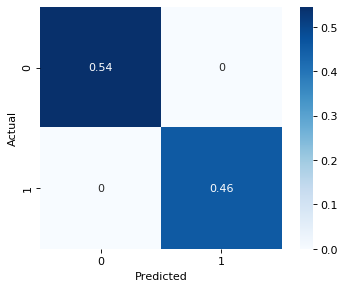

In [70]:
eda.make_confusion_matrix(model_knn_gscv, train_X, train_y, threshold=0.5)

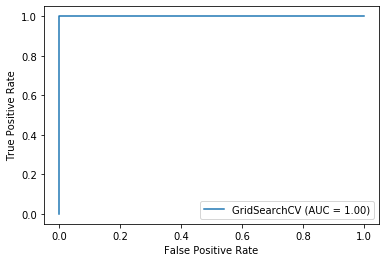

In [96]:
plot_roc_curve(model_knn_gscv, train_X, train_y);

Looks like overfitting again, just like with the smaller trawler dataset

In [71]:
model_logreg_cv = LogisticRegressionCV(cv=KFold(n_splits=5, shuffle=True, random_state=RANDOM))
model_logreg_cv.fit(train_X, train_y)

LogisticRegressionCV(Cs=10, class_weight=None,
                     cv=KFold(n_splits=5, random_state=42, shuffle=True),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='auto',
                     n_jobs=None, penalty='l2', random_state=None, refit=True,
                     scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [72]:
interactive(lambda threshold: eda.make_confusion_matrix(model_logreg_cv, test_X, test_y, threshold=0.28, show_metrics=True), threshold=(0.0,1.0,0.01))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

In [87]:
threshold = 0.37

logreg_y = (model_logreg_cv.predict_proba(train_X)[:, 1] >= threshold)

f1_score(train_y, logreg_y)

0.6863160347963542

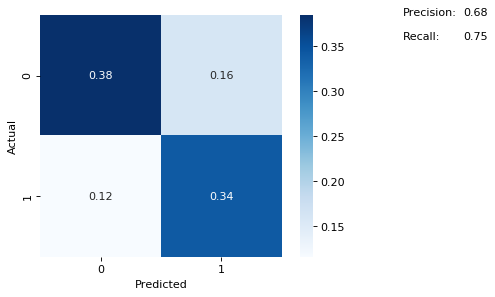

In [92]:
eda.make_confusion_matrix(model_logreg_cv, train_X, train_y, threshold=0.35, show_metrics=True)

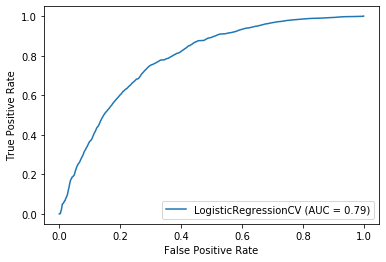

In [97]:
plot_roc_curve(model_logreg_cv, train_X, train_y);

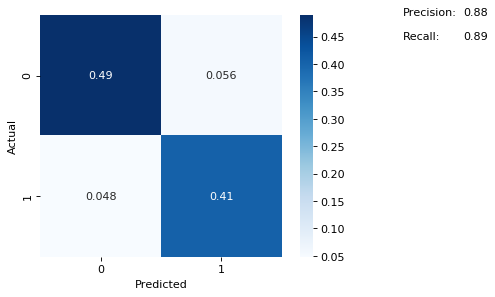

In [75]:
eda.make_confusion_matrix(model_knn_gscv, test_X, test_y, threshold=0.5, show_metrics=True)

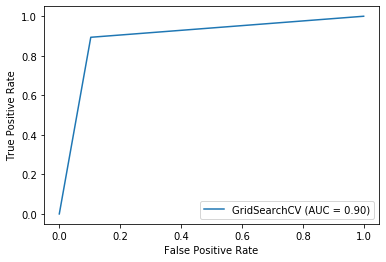

In [98]:
plot_roc_curve(model_knn_gscv, test_X, test_y);

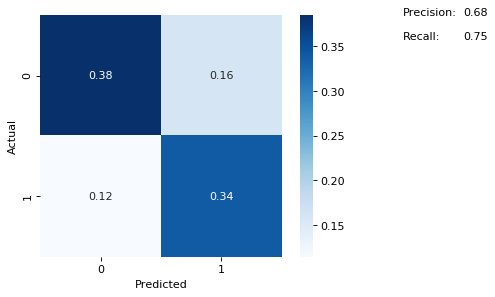

In [93]:
eda.make_confusion_matrix(model_logreg_cv, test_X, test_y, threshold=0.35, show_metrics=True)

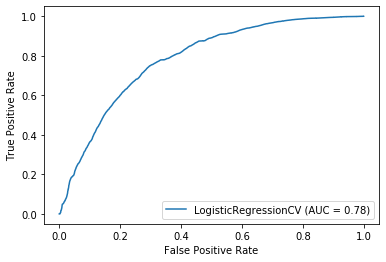

In [99]:
plot_roc_curve(model_logreg_cv, test_X, test_y);

KNN performs much better... but also has an extremely long training time

Let's save the two models

In [77]:
dump(model_knn_gscv, "knn_model_all.joblib")

['knn_model_all.joblib']

In [78]:
dump(model_logreg_cv, "lr_model_all.joblib")

['lr_model_all.joblib']

Let's see how the trawler models perform on the larger dataset

In [79]:
model_knn_trawler = load("knn_model_trawler.joblib")
model_knn2_trawler = load("knn2_model_trawler.joblib")
model_logreg_trawler = load("lr_model_trawler.joblib")

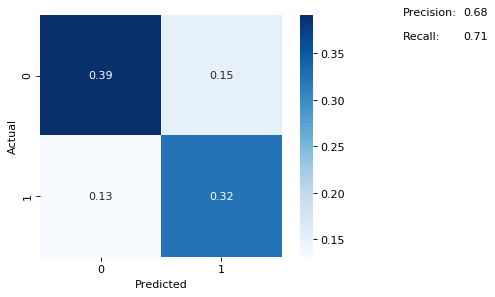

In [80]:
eda.make_confusion_matrix(model_logreg_trawler, test_X, test_y, threshold=0.28, show_metrics=True)

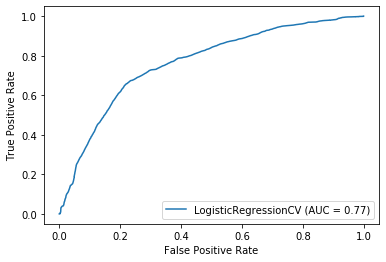

In [100]:
plot_roc_curve(model_logreg_trawler, test_X, test_y);

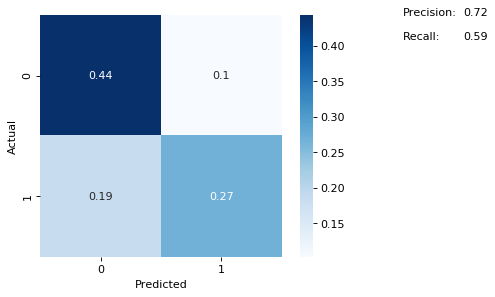

In [81]:
eda.make_confusion_matrix(model_knn_trawler, test_X, test_y, threshold=0.1, show_metrics=True)

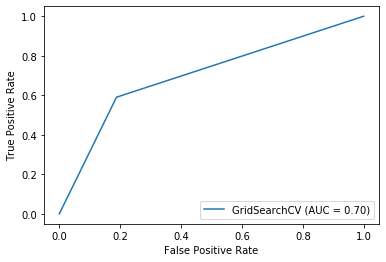

In [101]:
plot_roc_curve(model_knn_trawler, test_X, test_y);

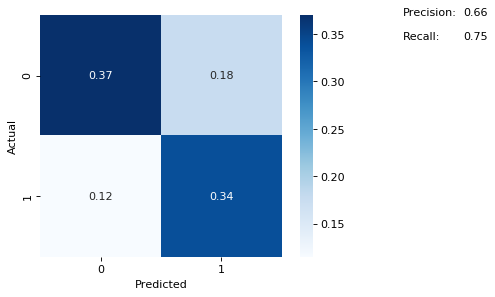

In [82]:
eda.make_confusion_matrix(model_knn2_trawler, test_X, test_y, threshold=0.01, show_metrics=True)

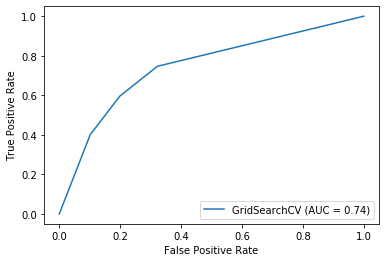

In [102]:
plot_roc_curve(model_knn2_trawler, test_X, test_y);

The overfitted KNN model appears to gradually perform worst with more unseen data, while the logistic regression model holds up much better. The second KNN (n_neighbour = 3) performs around the same as the logreg model, which is still a drop from its performance on trawlers alone.

Let's correct for KNN overfitting here too

In [83]:
model_knn2 = KNeighborsClassifier()

#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(2, 25)}

#use gridsearch to test all values for n_neighbors
model_knn2_gscv = GridSearchCV(model_knn2, param_grid, cv=KFold(n_splits=5, shuffle=True, random_state=RANDOM))

#fit model to data
model_knn2_gscv.fit(train_X, train_y)
model_knn2_gscv.best_params_

{'n_neighbors': 3}

n_neighbours is 3 again

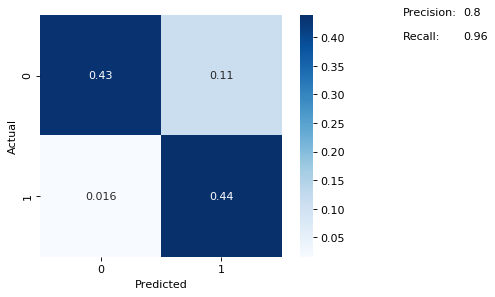

In [95]:
eda.make_confusion_matrix(model_knn2_gscv, test_X, test_y, threshold=0.01, show_metrics=True)

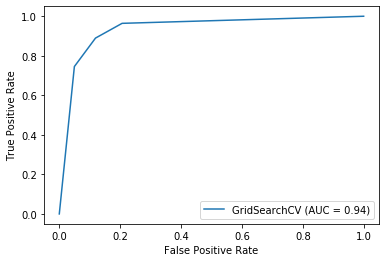

In [103]:
plot_roc_curve(model_knn2_gscv, test_X, test_y);

The best performance for now, but we've seen how the performance drops with more datapoints not in the original set.

In [86]:
dump(model_knn_gscv, "knn2_model_all.joblib")

['knn2_model_all.joblib']

Let's check against the non-consensus data

In [108]:
fishing_noconsensus_df['year'] = pd.DatetimeIndex(fishing_noconsensus_df['timestamp']).year
fishing_noconsensus_df['month'] = pd.DatetimeIndex(fishing_noconsensus_df['timestamp']).month
fishing_noconsensus_df['day'] = pd.DatetimeIndex(fishing_noconsensus_df['timestamp']).day
fishing_noconsensus_df['hour'] = pd.DatetimeIndex(fishing_noconsensus_df['timestamp']).hour
fishing_noconsensus_df['minute'] = pd.DatetimeIndex(fishing_noconsensus_df['timestamp']).minute

fishing_noconsensus_df['is_new_mmsi'] = (fishing_noconsensus_df.mmsi.shift(1) != fishing_noconsensus_df.mmsi.shift(0))

prev_list = ['speed', 'lat', 'lon']
for col in prev_list:
    fishing_noconsensus_df['prev_' + col] = fishing_noconsensus_df[col].shift(1)
    fishing_noconsensus_df['prev_' + col][fishing_noconsensus_df.is_new_mmsi] = np.nan

fishing_noconsensus_df['dist_moved'] = fishing_noconsensus_df.apply(getdist, axis=1)

fishing_noconsensus_df['time_taken'] = fishing_noconsensus_df.timestamp.diff(1)
fishing_noconsensus_df['time_taken'][fishing_noconsensus_df.is_new_mmsi] = np.nan

fishing_noconsensus_df = fishing_noconsensus_df.dropna()

noconsensus_X = fishing_noconsensus_df[feature_cols]
noconsensus_y = fishing_noconsensus_df['is_fishing']

In [110]:
noconsensus_y_knn = model_knn_gscv.predict(noconsensus_X)

noconsensus_y_knn

array([0., 0., 0., ..., 1., 0., 0.])